This notebook runs the event segmentation analyses.

## Import libraries

In [25]:
import numpy as np
import pandas as pd
import brainiak.eventseg.event as event
import hypertools as hyp
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
import pickle

def score_model(mcorr, model, k, s):
    i1, i2 = np.where(np.round(model.segments_[0])==1)
    w = np.zeros_like(model.segments_[0])
    w[i1,i2] = 1
    w = np.dot(w, w.T).astype(bool)
    return mcorr[w].mean()/mcorr[~w].mean() - k/s
    
def reduce_model(m, ev):
    """Reduce a model based on event labels"""
    w = (np.round(ev.segments_[0])==1).astype(bool)
    return np.array([m[wi, :].mean(0) for wi in w.T])

%matplotlib inline

## Setting paths

In [2]:
datadir = '../../../data/processed/'

## Load data

In [3]:
video_model, recall_models = np.load(datadir+'models_t100_v50_r10_resampled.npy', allow_pickle=True)

## Find optimal k for video model

In [4]:
m=[]
corrmat = np.corrcoef(video_model)
for i, events in enumerate(range(2, 51)):
    ev = event.EventSegment(events)
    ev.fit(video_model)
    t = np.round(ev.segments_[0]).astype(int)
    mask = np.sum(list(map(lambda x: np.outer(x, x), t.T)), 0).astype(bool)
    within = corrmat[mask].mean()
    across = corrmat[~mask].mean()
    m.append((within, across, within/across))

fitting to 2 events...
fitting to 3 events...
fitting to 4 events...
fitting to 5 events...
fitting to 6 events...
fitting to 7 events...
fitting to 8 events...
fitting to 9 events...
fitting to 10 events...
fitting to 11 events...
fitting to 12 events...
fitting to 13 events...
fitting to 14 events...
fitting to 15 events...
fitting to 16 events...
fitting to 17 events...
fitting to 18 events...
fitting to 19 events...
fitting to 20 events...
fitting to 21 events...
fitting to 22 events...
fitting to 23 events...
fitting to 24 events...
fitting to 25 events...
fitting to 26 events...
fitting to 27 events...
fitting to 28 events...
fitting to 29 events...
fitting to 30 events...
fitting to 31 events...
fitting to 32 events...
fitting to 33 events...
fitting to 34 events...
fitting to 35 events...
fitting to 36 events...
fitting to 37 events...
fitting to 38 events...
fitting to 39 events...
fitting to 40 events...
fitting to 41 events...
fitting to 42 events...
fitting to 43 events...


## Plot the within and across correlation values as a function of k

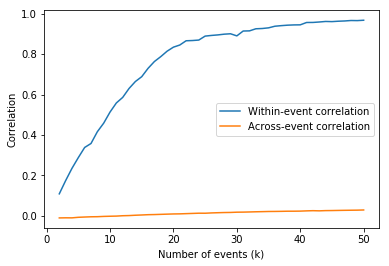

In [30]:
plt.plot([np.nan]*2 + list(map(lambda x: x[0], m)), label='Within-event correlation')
plt.plot([np.nan]*2 + list(map(lambda x: x[1], m)), label='Across-event correlation')
plt.legend()
plt.ylabel('Correlation')
plt.xlabel('Number of events (k)')
plt.show()

## Plot the ratio of within/across ratio as a function of k

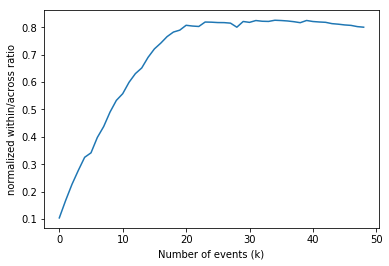

In [55]:
t=list(map(lambda x: x[0]/(x[1]-min([i[2] for i in m])), m))
t/=np.max(t)
for i, v in enumerate(t):
    t[i]-=(i+2)/250
plt.plot(t, label='Within-event correlation')
plt.ylabel('normalized within/across ratio')
plt.xlabel('Number of events (k)')
maxk_video = np.argmax(t) + 2

## Fit event segmentation model to video

In [56]:
ev = event.EventSegment(maxk_video)
ev.fit(video_model)
video_events = reduce_model(video_model, ev)

## Save models

In [57]:
with open('../../../data/processed/video_eventseg_model', 'wb') as f:
    pickle.dump(ev, f)
np.save('../../../data/processed/video_events', video_events)

## Get video event times

In [58]:
video_event_times = []
for s in ev.segments_[0].T:
    tp = np.where(np.round(s)==1)[0]
    video_event_times.append((tp[0], tp[-1]))
np.save(datadir+'video_event_times', video_event_times)

## Fit event segmentation model to recall

In [77]:
ks = list(range(2, 51))
sub_cs = {}

for i, sub in enumerate(recall_models):
    mcorr = np.corrcoef(sub)
    cs = []
    for k in ks:
        print(f'\tfitting to {k} events...')
        ev = event.EventSegment(k)
        ev.fit(sub)
        i1, i2 = np.where(np.round(ev.segments_[0])==1)
        w = np.zeros_like(ev.segments_[0])
        w[i1,i2] = 1
        w = np.dot(w, w.T).astype(bool)
        within = mcorr[w].mean()
        across = mcorr[~w].mean()
        cs.append((within, across, within/across))
        
    sub_cs[i] = cs
    
#     cs_new = list(map(lambda x: x[0]/(x[1]-min([i[2] for i in cs])), cs))
#     cs_new /= np.max(cs_new)
#     for i, c_new in enumerate(cs_new):
#         cs_new[i] -= (i+2)/50
#     m_new = ks[np.argmax(cs_new)]
#     maxk_new.append(m_new)
        
    
#     m = ks[np.argmax(cs)]
#     maxk.append(m)

subject 1:
	fitting to 2 events...
	fitting to 3 events...
	fitting to 4 events...
	fitting to 5 events...
	fitting to 6 events...
	fitting to 7 events...
	fitting to 8 events...
	fitting to 9 events...
	fitting to 10 events...
	fitting to 11 events...
	fitting to 12 events...
	fitting to 13 events...
	fitting to 14 events...
	fitting to 15 events...
	fitting to 16 events...
	fitting to 17 events...
	fitting to 18 events...
	fitting to 19 events...
	fitting to 20 events...
	fitting to 21 events...
	fitting to 22 events...
	fitting to 23 events...
	fitting to 24 events...
	fitting to 25 events...
	fitting to 26 events...
	fitting to 27 events...
	fitting to 28 events...
	fitting to 29 events...
	fitting to 30 events...
	fitting to 31 events...
	fitting to 32 events...
	fitting to 33 events...
	fitting to 34 events...
	fitting to 35 events...
	fitting to 36 events...
	fitting to 37 events...
	fitting to 38 events...
	fitting to 39 events...
	fitting to 40 events...
	fitting to 41 events.

	fitting to 28 events...
	fitting to 29 events...
	fitting to 30 events...
	fitting to 31 events...
	fitting to 32 events...
	fitting to 33 events...
	fitting to 34 events...
	fitting to 35 events...
	fitting to 36 events...
	fitting to 37 events...
	fitting to 38 events...
	fitting to 39 events...
	fitting to 40 events...
	fitting to 41 events...
	fitting to 42 events...
	fitting to 43 events...
	fitting to 44 events...
	fitting to 45 events...
	fitting to 46 events...
	fitting to 47 events...
	fitting to 48 events...
	fitting to 49 events...
	fitting to 50 events...
	MAXK_OLD = 17
	MAXK_NEW = 20
subject 8:
	fitting to 2 events...
	fitting to 3 events...
	fitting to 4 events...
	fitting to 5 events...
	fitting to 6 events...
	fitting to 7 events...
	fitting to 8 events...
	fitting to 9 events...
	fitting to 10 events...
	fitting to 11 events...
	fitting to 12 events...
	fitting to 13 events...
	fitting to 14 events...
	fitting to 15 events...
	fitting to 16 events...
	fitting to 17 ev

	fitting to 3 events...
	fitting to 4 events...
	fitting to 5 events...
	fitting to 6 events...
	fitting to 7 events...
	fitting to 8 events...
	fitting to 9 events...
	fitting to 10 events...
	fitting to 11 events...
	fitting to 12 events...
	fitting to 13 events...
	fitting to 14 events...
	fitting to 15 events...
	fitting to 16 events...
	fitting to 17 events...
	fitting to 18 events...
	fitting to 19 events...
	fitting to 20 events...
	fitting to 21 events...
	fitting to 22 events...
	fitting to 23 events...
	fitting to 24 events...
	fitting to 25 events...
	fitting to 26 events...
	fitting to 27 events...
	fitting to 28 events...
	fitting to 29 events...
	fitting to 30 events...
	fitting to 31 events...
	fitting to 32 events...
	fitting to 33 events...
	fitting to 34 events...
	fitting to 35 events...
	fitting to 36 events...
	fitting to 37 events...
	fitting to 38 events...
	fitting to 39 events...
	fitting to 40 events...
	fitting to 41 events...
	fitting to 42 events...
	fittin

In [131]:
sns.set_style('ticks')
sns.set_context('talk')

In [158]:
fig, axarr = plt.subplots(nrows=5, ncols=4)
fig.set_size_inches(20,20)
axarr = axarr.flatten()

for (sub, cs), ax in zip(sub_cs.items(), axarr):
    ax.plot([np.nan]*2 + list(map(lambda x: x[0], cs)), label='Within-event correlation')
    ax.plot([np.nan]*2 + list(map(lambda x: x[1], cs)), label='Across-event correlation')
    ax.legend()
    ax.set_ylabel('Correlation')
    ax.set_xlabel('Number of events (k)')
    ax.set_title(f'Subject {sub+1}')
    
axarr[-3].axis('off')
axarr[-2].axis('off')
axarr[-1].axis('off')
plt.tight_layout()
plt.subplots_adjust()
plt.show()

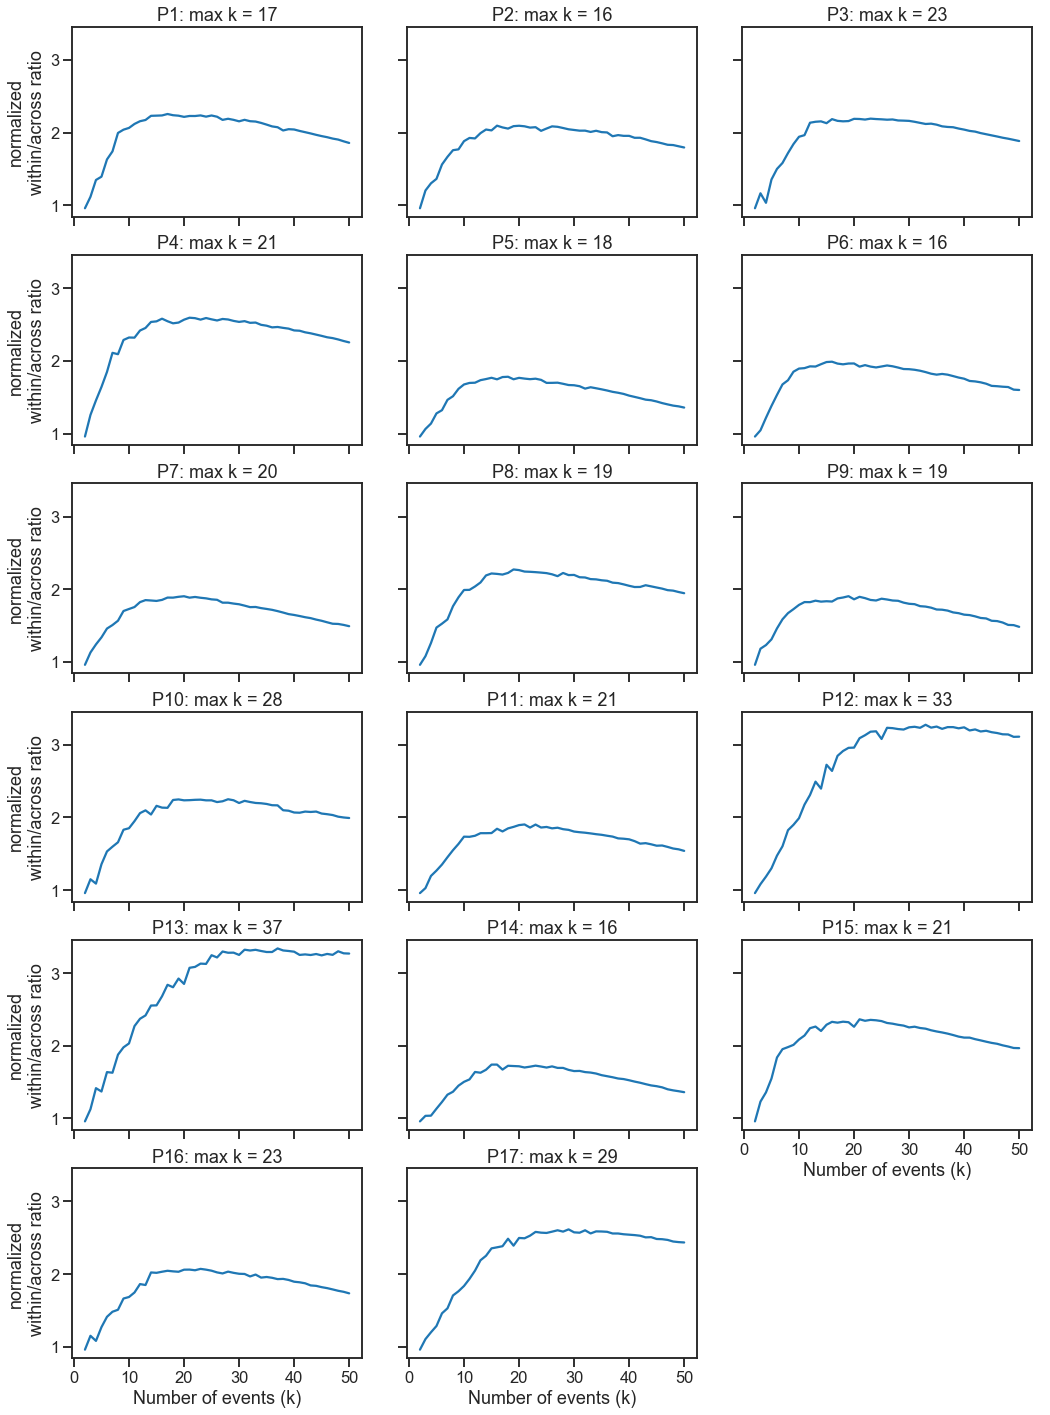

In [161]:
fig, axarr = plt.subplots(nrows=6, ncols=3, sharey=True)
fig.set_size_inches(15,20)
axarr = axarr.flatten()

ks = list(range(2, 51))
maxk_rec = []

for (sub, cs), ax in zip(sub_cs.items(), axarr):
    ratios = list(map(lambda x: x[0]/(x[1]-min([i[2] for i in cs])), cs))
    ratios /= np.max(ratios)
    for i, ratio in enumerate(ratios):
        ratios[i] -= (i+2)/50
        
    m = ks[np.argmax(ratios)]
    maxk_rec.append(m)
    
    ax.plot([np.nan]*2 + list(ratios))
    ax.set_xticks(list(range(0, 51, 10)))
    
    if not sub % 3:
        ax.set_ylabel('normalized\nwithin/across ratio')
        ax.set_yticks(list(range(6)))
    else:
        ax.set_ylabel('')

    if sub >= 14:
        ax.set_xlabel('Number of events (k)')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels([])
        
    ax.set_title(f'P{sub+1}: max k = {m}')
    
axarr[-1].axis('off')
plt.tight_layout()
plt.subplots_adjust(hspace=.2)
plt.show()

## Fit model to recall using best k

In [168]:
recall_events = []
recall_event_times = []
recall_eventseg_models = []
for i, k in enumerate(maxk_rec):
    ev = event.EventSegment(k)
    ev.fit(recall_models[i])
    m = reduce_model(recall_models[i], ev)
    recall_events.append(m)
    recall_times = []
    for s in ev.segments_[0].T:
        tp = np.where(np.round(s)==1)[0]
        recall_times.append((tp[0], tp[-1]))
    recall_event_times.append(recall_times)
    recall_eventseg_models.append(ev)

## Create average recall model

In [171]:
matches = np.array([np.argmax(1 - cdist(video_events, r, 'correlation'), 0) for r in recall_events])
avg_recalls = [[] for _ in video_events]
for match, r in zip(matches, recall_events):
    for i, m in enumerate(match):
        avg_recalls[m].append(r[i,:])
avg_recall_events = np.array(list(map(lambda r: np.mean(r, 0) if len(r)>0 else np.zeros((100,)), avg_recalls)))

## Create 2D embeddings

In [172]:
np.random.seed(10)
embeddings_old = hyp.reduce(recall_events_old+[video_events]+[avg_recall_events_old], reduce='UMAP', ndims=2)

In [173]:
np.random.seed(10)
embeddings_new = hyp.reduce(recall_events_new+[video_events]+[avg_recall_events_new], reduce='UMAP', ndims=2)

## Save models

In [174]:
np.save(datadir+'avg_recall_events_old_resampled', avg_recall_events_old)
np.save(datadir+'embeddings_old_resampled', embeddings_old)
np.save(datadir+'labels_old_resampled', matches_old)
np.save(datadir+'recall_events_old_resampled', recall_events_old)
np.save(datadir+'recall_event_times_old_resampled', recall_event_times_old)
with open(datadir+'recall_eventseg_models_old_resampled', 'wb') as f:
    pickle.dump(recall_eventseg_models_old, f)

In [175]:
np.save(datadir+'avg_recall_events_new_resampled', avg_recall_events_new)
np.save(datadir+'embeddings_new_resampled', embeddings_new)
np.save(datadir+'labels_new_resampled', matches_new)
np.save(datadir+'recall_events_new_resampled', recall_events_new)
np.save(datadir+'recall_event_times_new_resampled', recall_event_times_new)
with open(datadir+'recall_eventseg_models_new_resampled', 'wb') as f:
    pickle.dump(recall_eventseg_models_new, f)

In [183]:
maxk_old

[14, 16, 12, 7, 15, 10, 17, 14, 11, 18, 20, 26, 27, 15, 12, 14, 27]

In [182]:
maxk_new

[17, 16, 23, 21, 18, 16, 20, 19, 19, 28, 21, 33, 37, 16, 21, 23, 29]